# Contenido
* [Casos totales](#1.)
* [Nuevos casos](#2.)

In [2]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [3]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [4]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y


## Defining functions. 
#### Code from https://github.com/LucaAngioloni/fit-COVID19

In [5]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [6]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    descr = 'Fit parameters: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    
    start = (len(ydata) - days_past - 1) % show_every


    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'r-', linewidth=6, label='fit')
    ax.bar(date_xdata, ydata, label='data')
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')
    
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

## Reading data

In [7]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [8]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

dates=pd.to_datetime(Spain.fecha.values)

last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

# Total confirmed cases <a class="anchor" id="1."></a>

Fit parameters: L=59750.819, k=0.279, x0=-0.727, y0=0.000
[5.44158586e+03 1.43715044e-02 6.12938367e-01 1.90734152e+02]


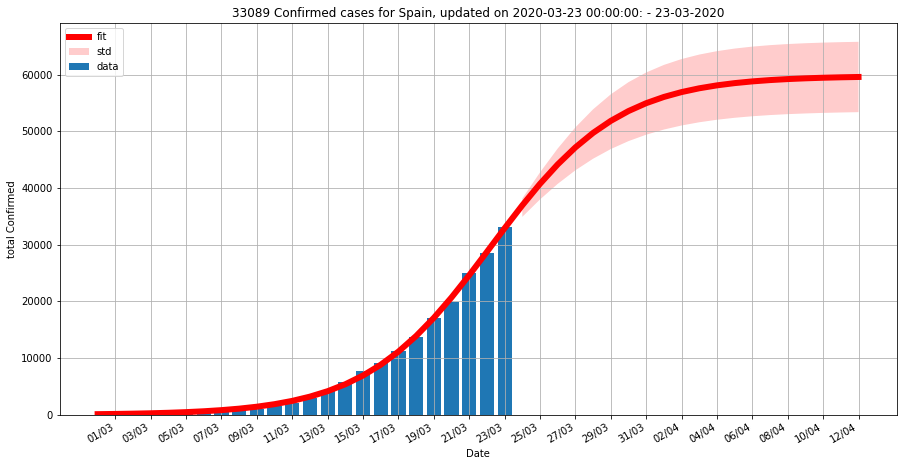

In [9]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on {}:'.format(Confirmed[-1],dates[-1])
p_cont, err_cont = fit_curve(logistic, Confirmed, Titulo , 'total Confirmed', last_date, coeff_std);

Number of deaths 2182


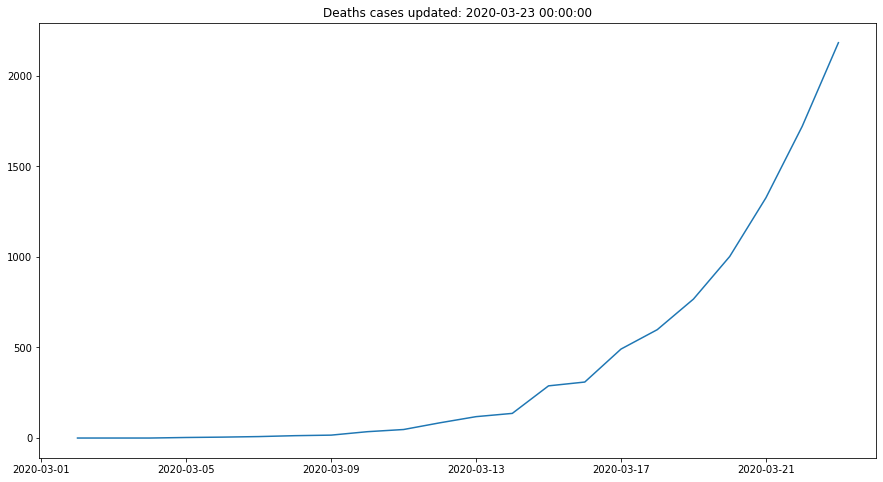

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

Fit parameters: L=7888.819, k=0.313, x0=3.084, y0=0.000
[2.19194046e+03 1.80931571e-02 1.36165742e+00 9.95169238e+00]


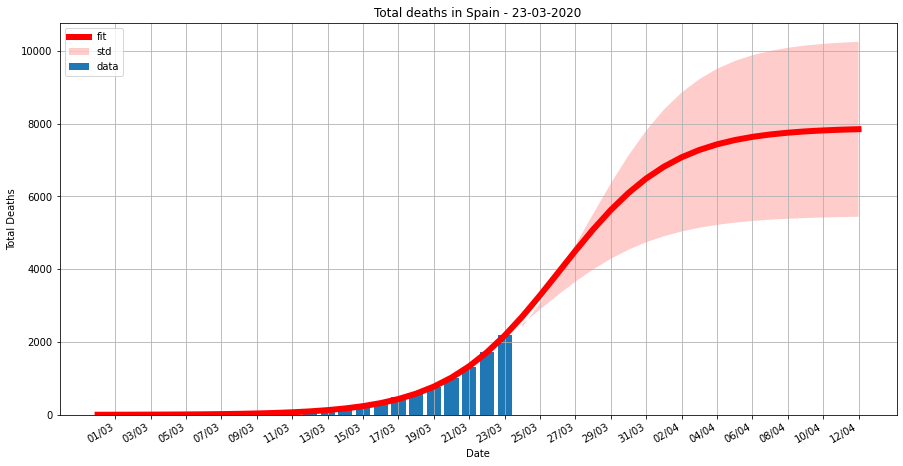

In [11]:
p_dead, err_dead = fit_curve(logistic, Deaths, 'Total deaths in Spain', 'Total Deaths', last_date, coeff_std)

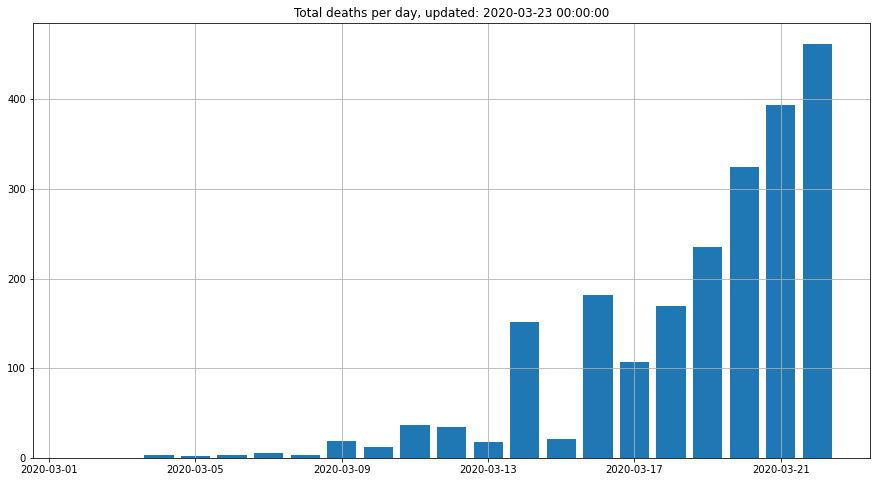

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(dates[:-1],np.diff(Deaths))
ax.set_title("Total deaths per day, updated: {}".format(dates[-1]));
ax.grid()

# Nuevos casos <a class="anchor" id="2."></a>

## En toda España

Fit parameters: L=72260.441, k=0.249, x0=1.058
[1.78745112e+04 3.77207797e-02 1.75135794e+00]


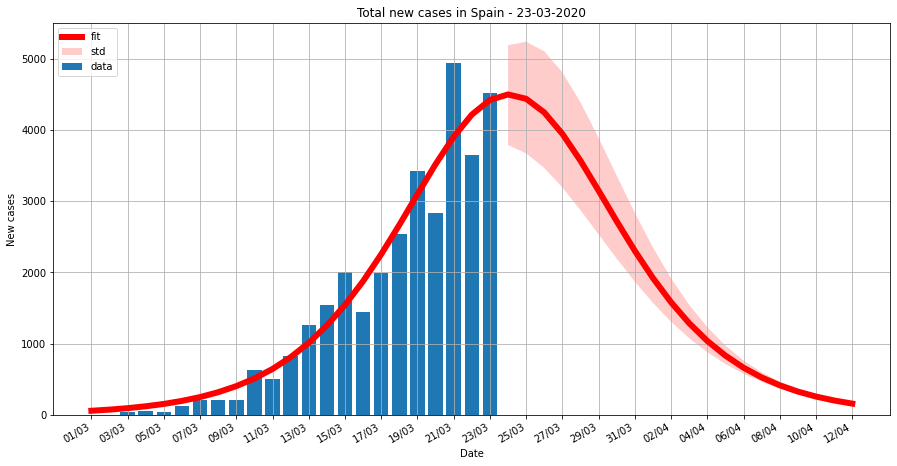

In [12]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} new cases for Spain, updated on {}:'.format(newCases[-1],dates[-1])
fit_curve(logistic_derivative, newCases, 'Total new cases in Spain', 'New cases', last_date, coeff_std_d);

In [13]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

In [14]:
growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

### Growth rates in Spain

In [15]:
print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth factor for the last 5 days: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 1.239
Mean growth factor for the last 5 days: 1.180


### nuevos casos por CCAA ajustados a una logistic curve

Fit parameters: L=3150.751, k=0.297, x0=-1.324
[5.14717798e+02 4.52022480e-02 9.63253641e-01]
Fit parameters: L=15352.858, k=0.195, x0=16.472
[1.67271575e+05 8.73675129e-02 6.49597799e+01]
Fit parameters: L=822.839, k=0.364, x0=-1.788
[2.33904873e+02 1.09447773e-01 1.33441751e+00]
Fit parameters: L=1017.215, k=0.320, x0=1.853
[7.18574635e+02 1.09468510e-01 3.81145812e+00]
Fit parameters: L=3950.600, k=0.283, x0=0.588
[2.02859340e+03 9.59858512e-02 3.22497066e+00]
Fit parameters: L=1000.077, k=0.285, x0=0.946
[2.46173044e+02 4.31696014e-02 1.52497372e+00]
Fit parameters: L=380.342, k=0.800, x0=-1.252
[40.08445873  0.10415274  0.21393438]
Fit parameters: L=2242.876, k=0.639, x0=-1.279
[3.87312582e+02 1.28826355e-01 4.47599934e-01]
Fit parameters: L=3066.949, k=0.406, x0=-1.088
[3.57073825e+02 4.62753644e-02 4.97916790e-01]
Fit parameters: L=14745.315, k=0.287, x0=1.701
[8.15861247e+03 8.27550407e-02 3.35770222e+00]
Fit parameters: L=1.848, k=8.657, x0=-3.000
[18.09917067 84.77580702  9.7

/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':


Fit parameters: L=200000.000, k=0.107, x0=51.925
[3.64289462e+07 8.38523054e-02 1.75414895e+03]
Fit parameters: L=16620.590, k=0.240, x0=-2.245
[4.63291034e+03 6.63402072e-02 1.99202414e+00]
Fit parameters: L=25.430, k=0.824, x0=-5.929
[5.78616976 0.23141597 0.48569981]
Fit parameters: L=756.957, k=0.277, x0=1.047
[2.57344224e+02 5.69719489e-02 2.16314053e+00]
Fit parameters: L=1616.526, k=0.264, x0=-0.468
[4.45270749e+02 5.80405524e-02 1.84771049e+00]
Fit parameters: L=6762.686, k=0.237, x0=3.014
[4.83800678e+03 7.27746802e-02 5.10395105e+00]


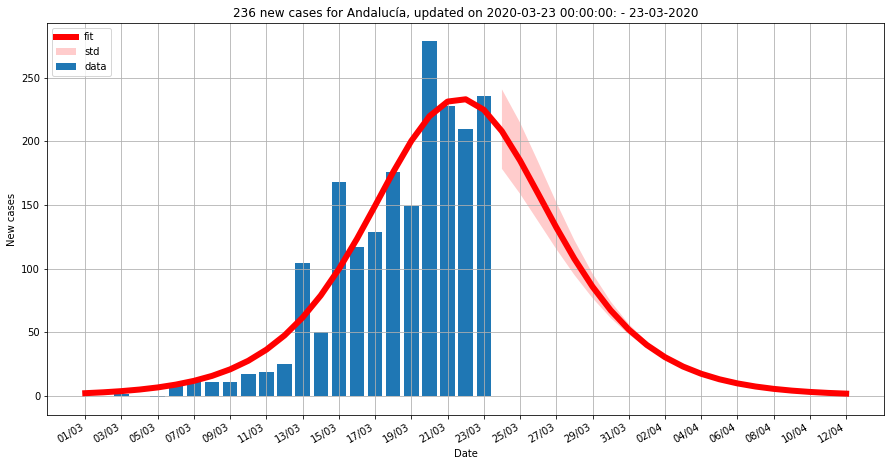

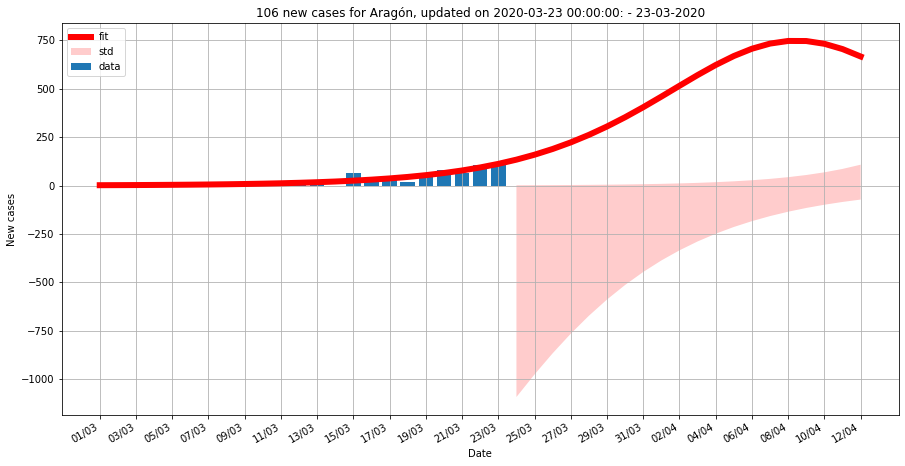

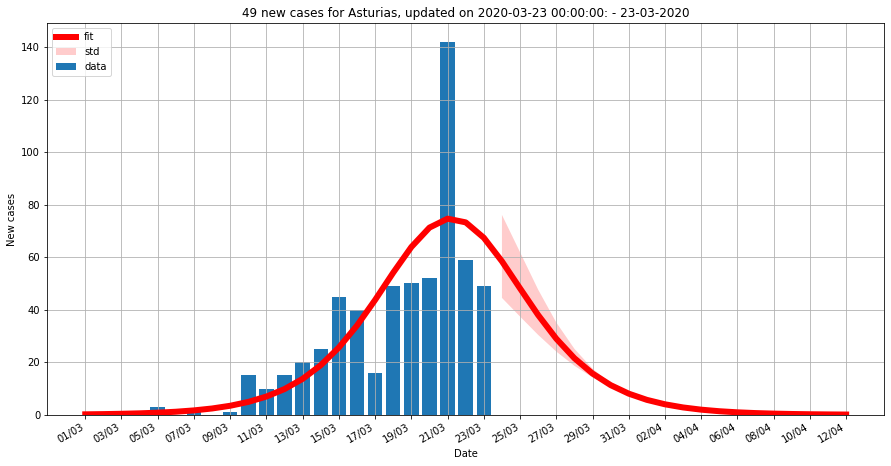

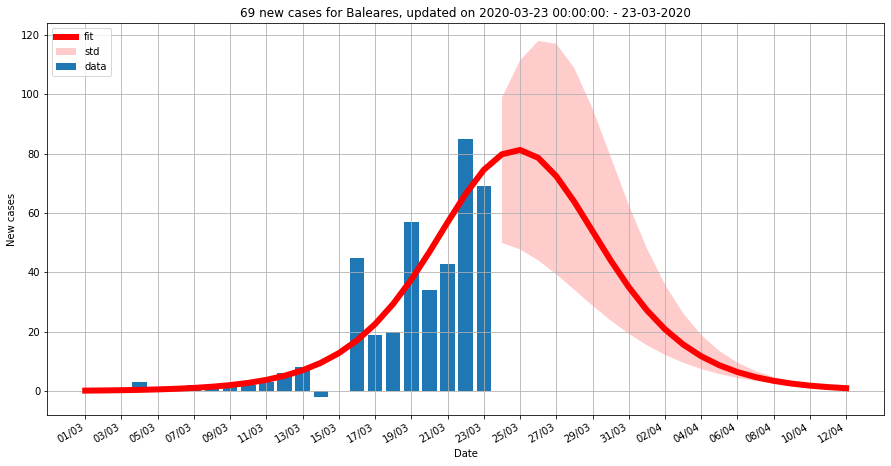

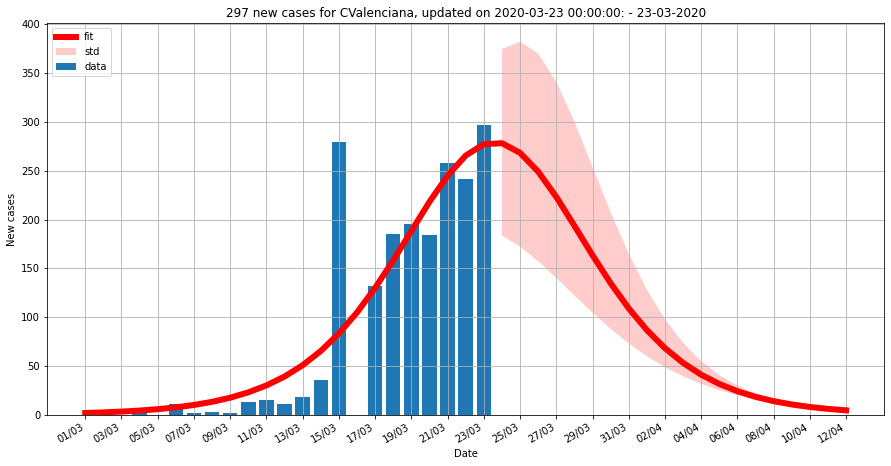

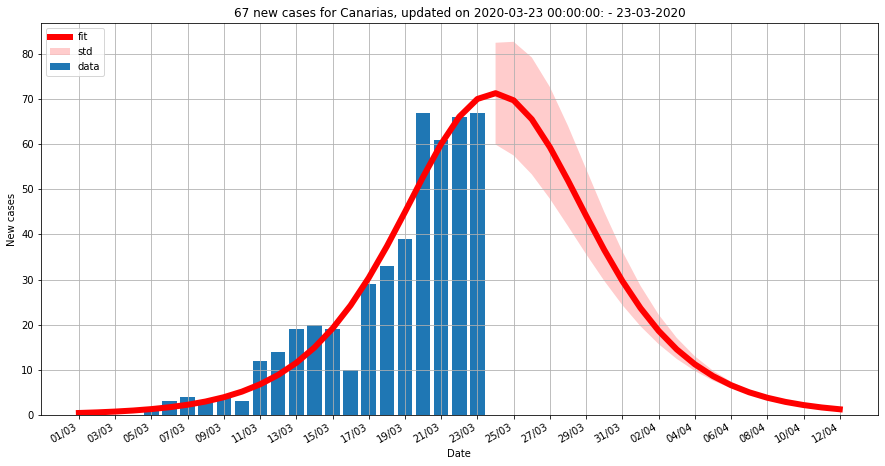

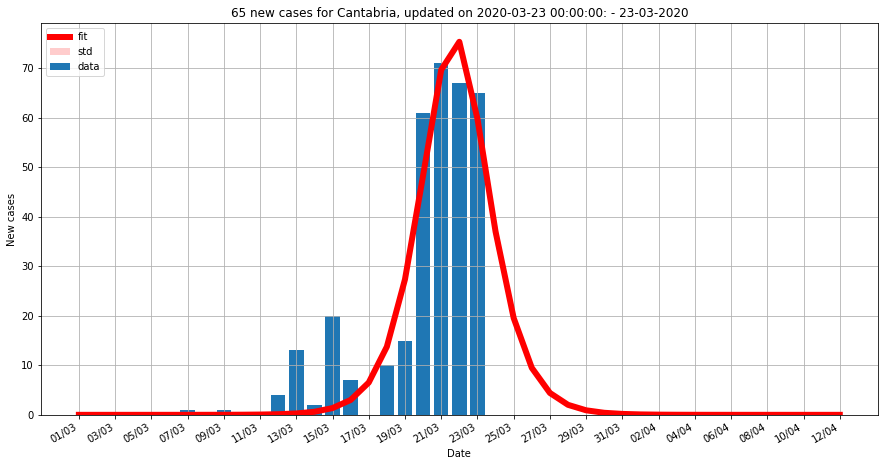

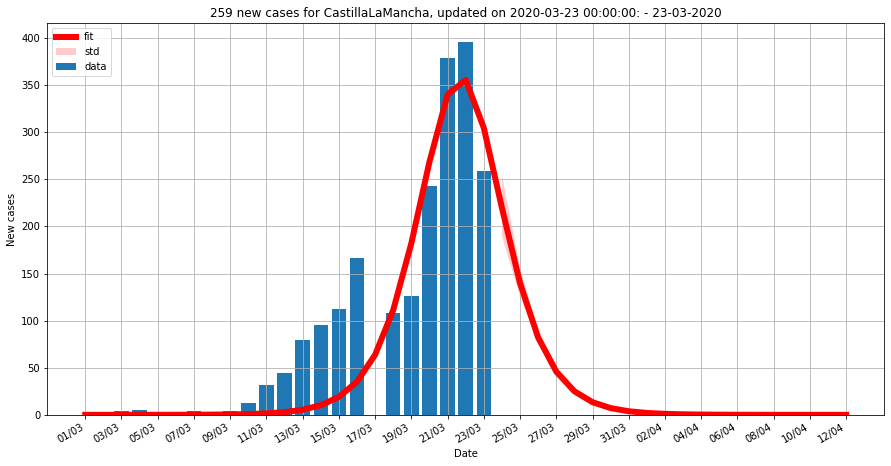

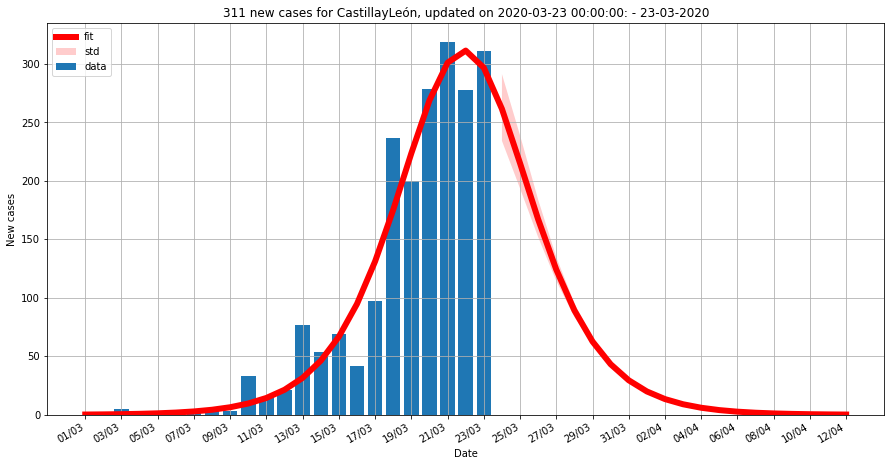

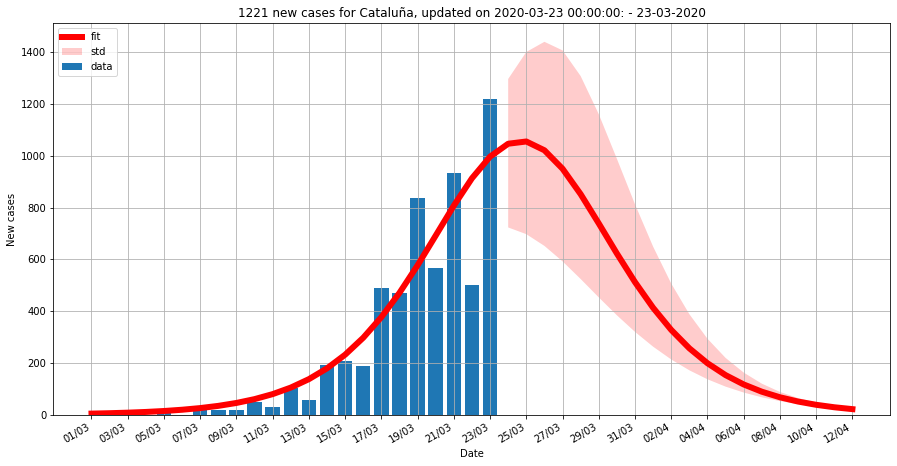

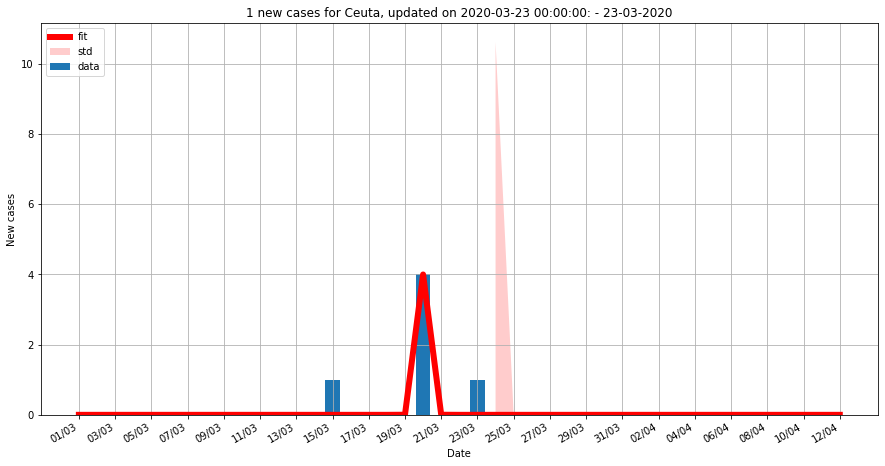

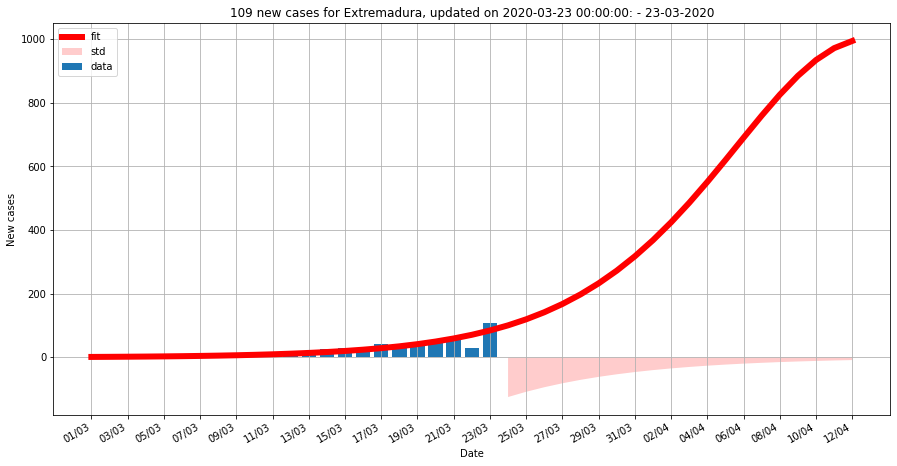

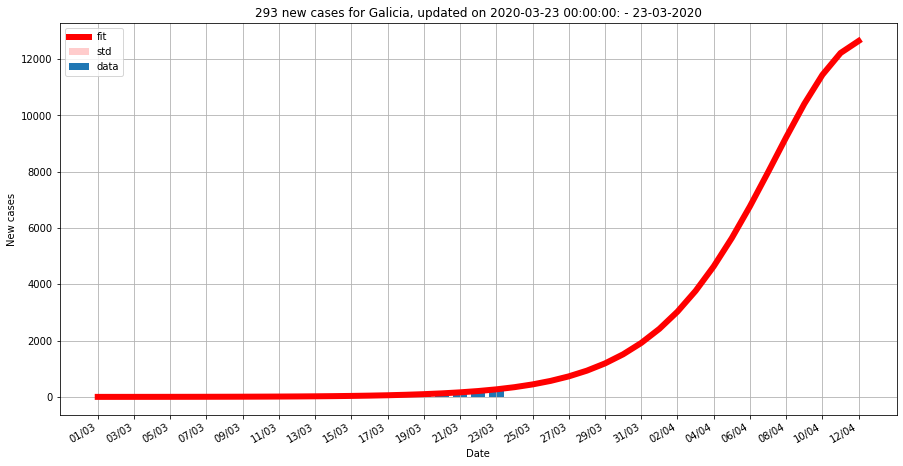

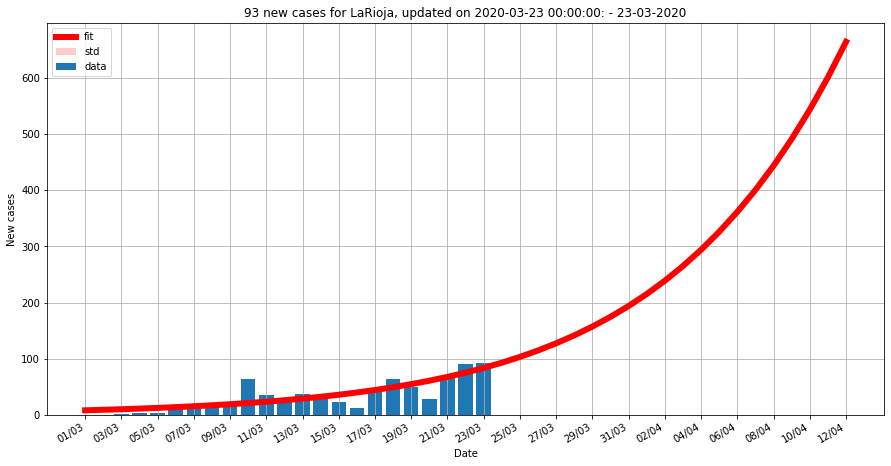

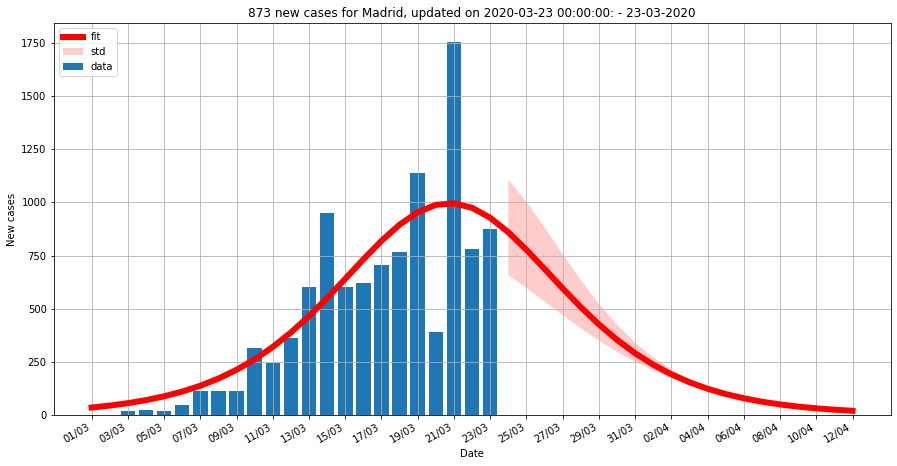

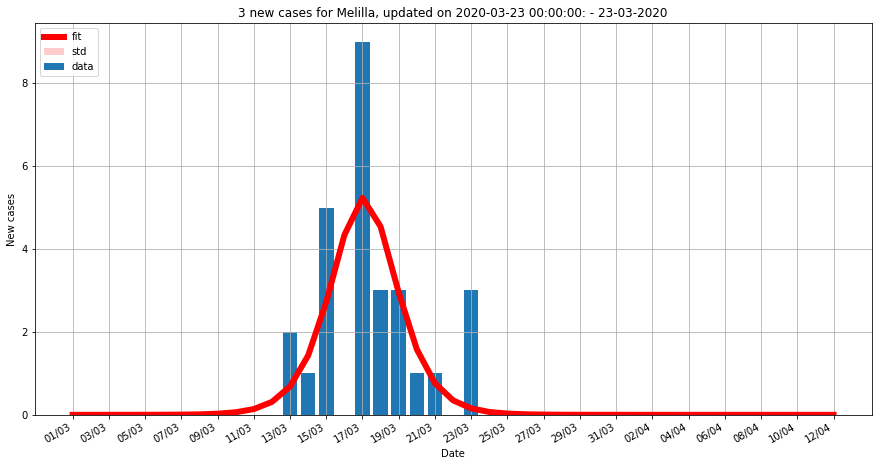

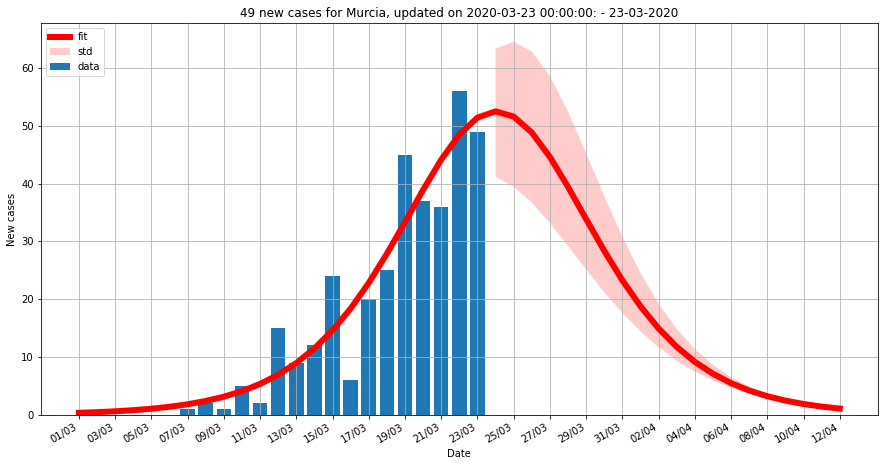

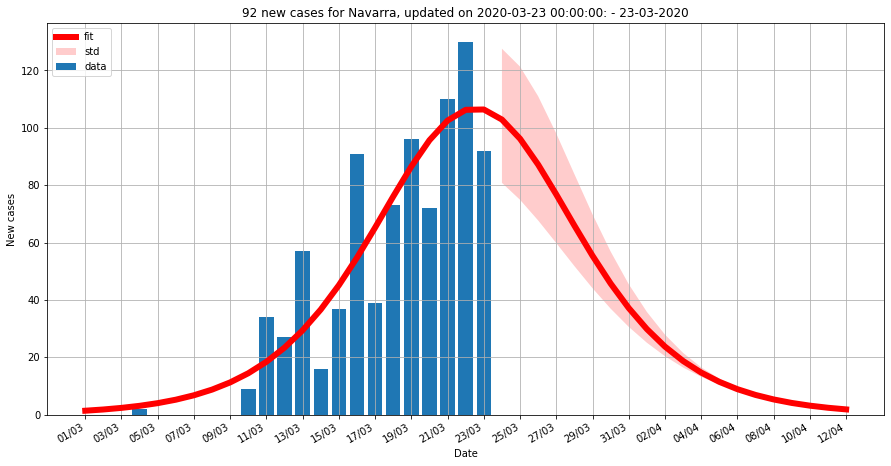

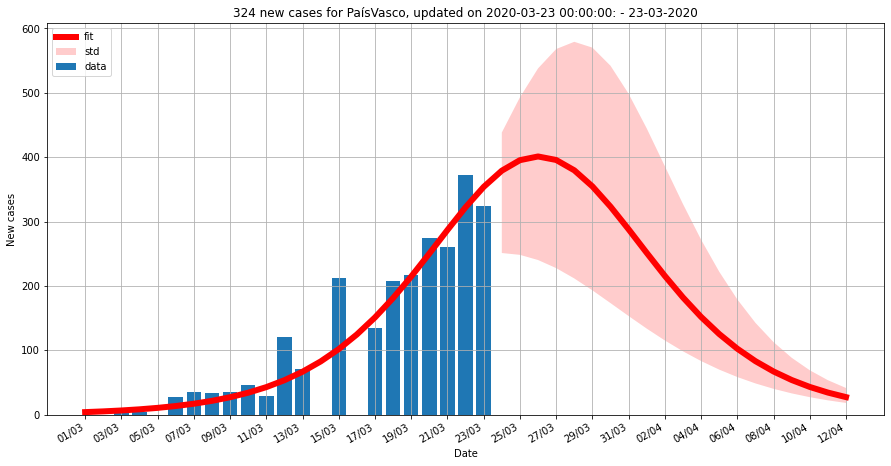

In [16]:
for CCAA in data.CCAA.unique():
    newCasesCCAA = np.diff(data[data.CCAA==CCAA].casos.values)
    Titulo = '{:.0f} new cases for {}, updated on {}:'.format(newCasesCCAA[-1],CCAA,dates[-1])
    fit_curve(logistic_derivative, newCasesCCAA, Titulo, 'New cases', last_date, coeff_std_d);